# Group 1
Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Biggiogera

This notebook contains the code that we used to run the Exploratory analysis of our data on. This contains considerations and code for how we selected the pictures and some considerations on the physical and conceptual features of the pictures we selected.In particular we also used to cluster species on the standard images.

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import seaborn as sb
import warnings

## Exploratory Analysis: Part 0 Understanding how to sample from multiple families

In [2]:
#Reading each species name and the amount of pictures for it
mammals_dist = defaultdict(int)
reptiles_dist = defaultdict(int)
birds_dist = defaultdict(int)
insects_dist = defaultdict(int)

for i in os.listdir('/Volumes/Jacopo Backup/split_2/Mammalia'):
    if i != '.DS_Store':
        mammals_dist[i]= len(os.listdir('/Volumes/Jacopo Backup/split_2/Mammalia/'+i))

for i in os.listdir('/Volumes/Jacopo Backup/split_1/Reptilia'):
    if i != '.DS_Store':
        reptiles_dist[i]= len(os.listdir('/Volumes/Jacopo Backup/split_1/Reptilia/'+i))

for i in os.listdir('/Volumes/Jacopo Backup/Aves'):
    if i != '.DS_Store':
        birds_dist[i]= len(os.listdir('/Volumes/Jacopo Backup/Aves/'+i))

for i in os.listdir('/Volumes/Jacopo Backup/Insecta'):
    if i != '.DS_Store':
        insects_dist[i]= len(os.listdir('/Volumes/Jacopo Backup/Insecta/'+i))

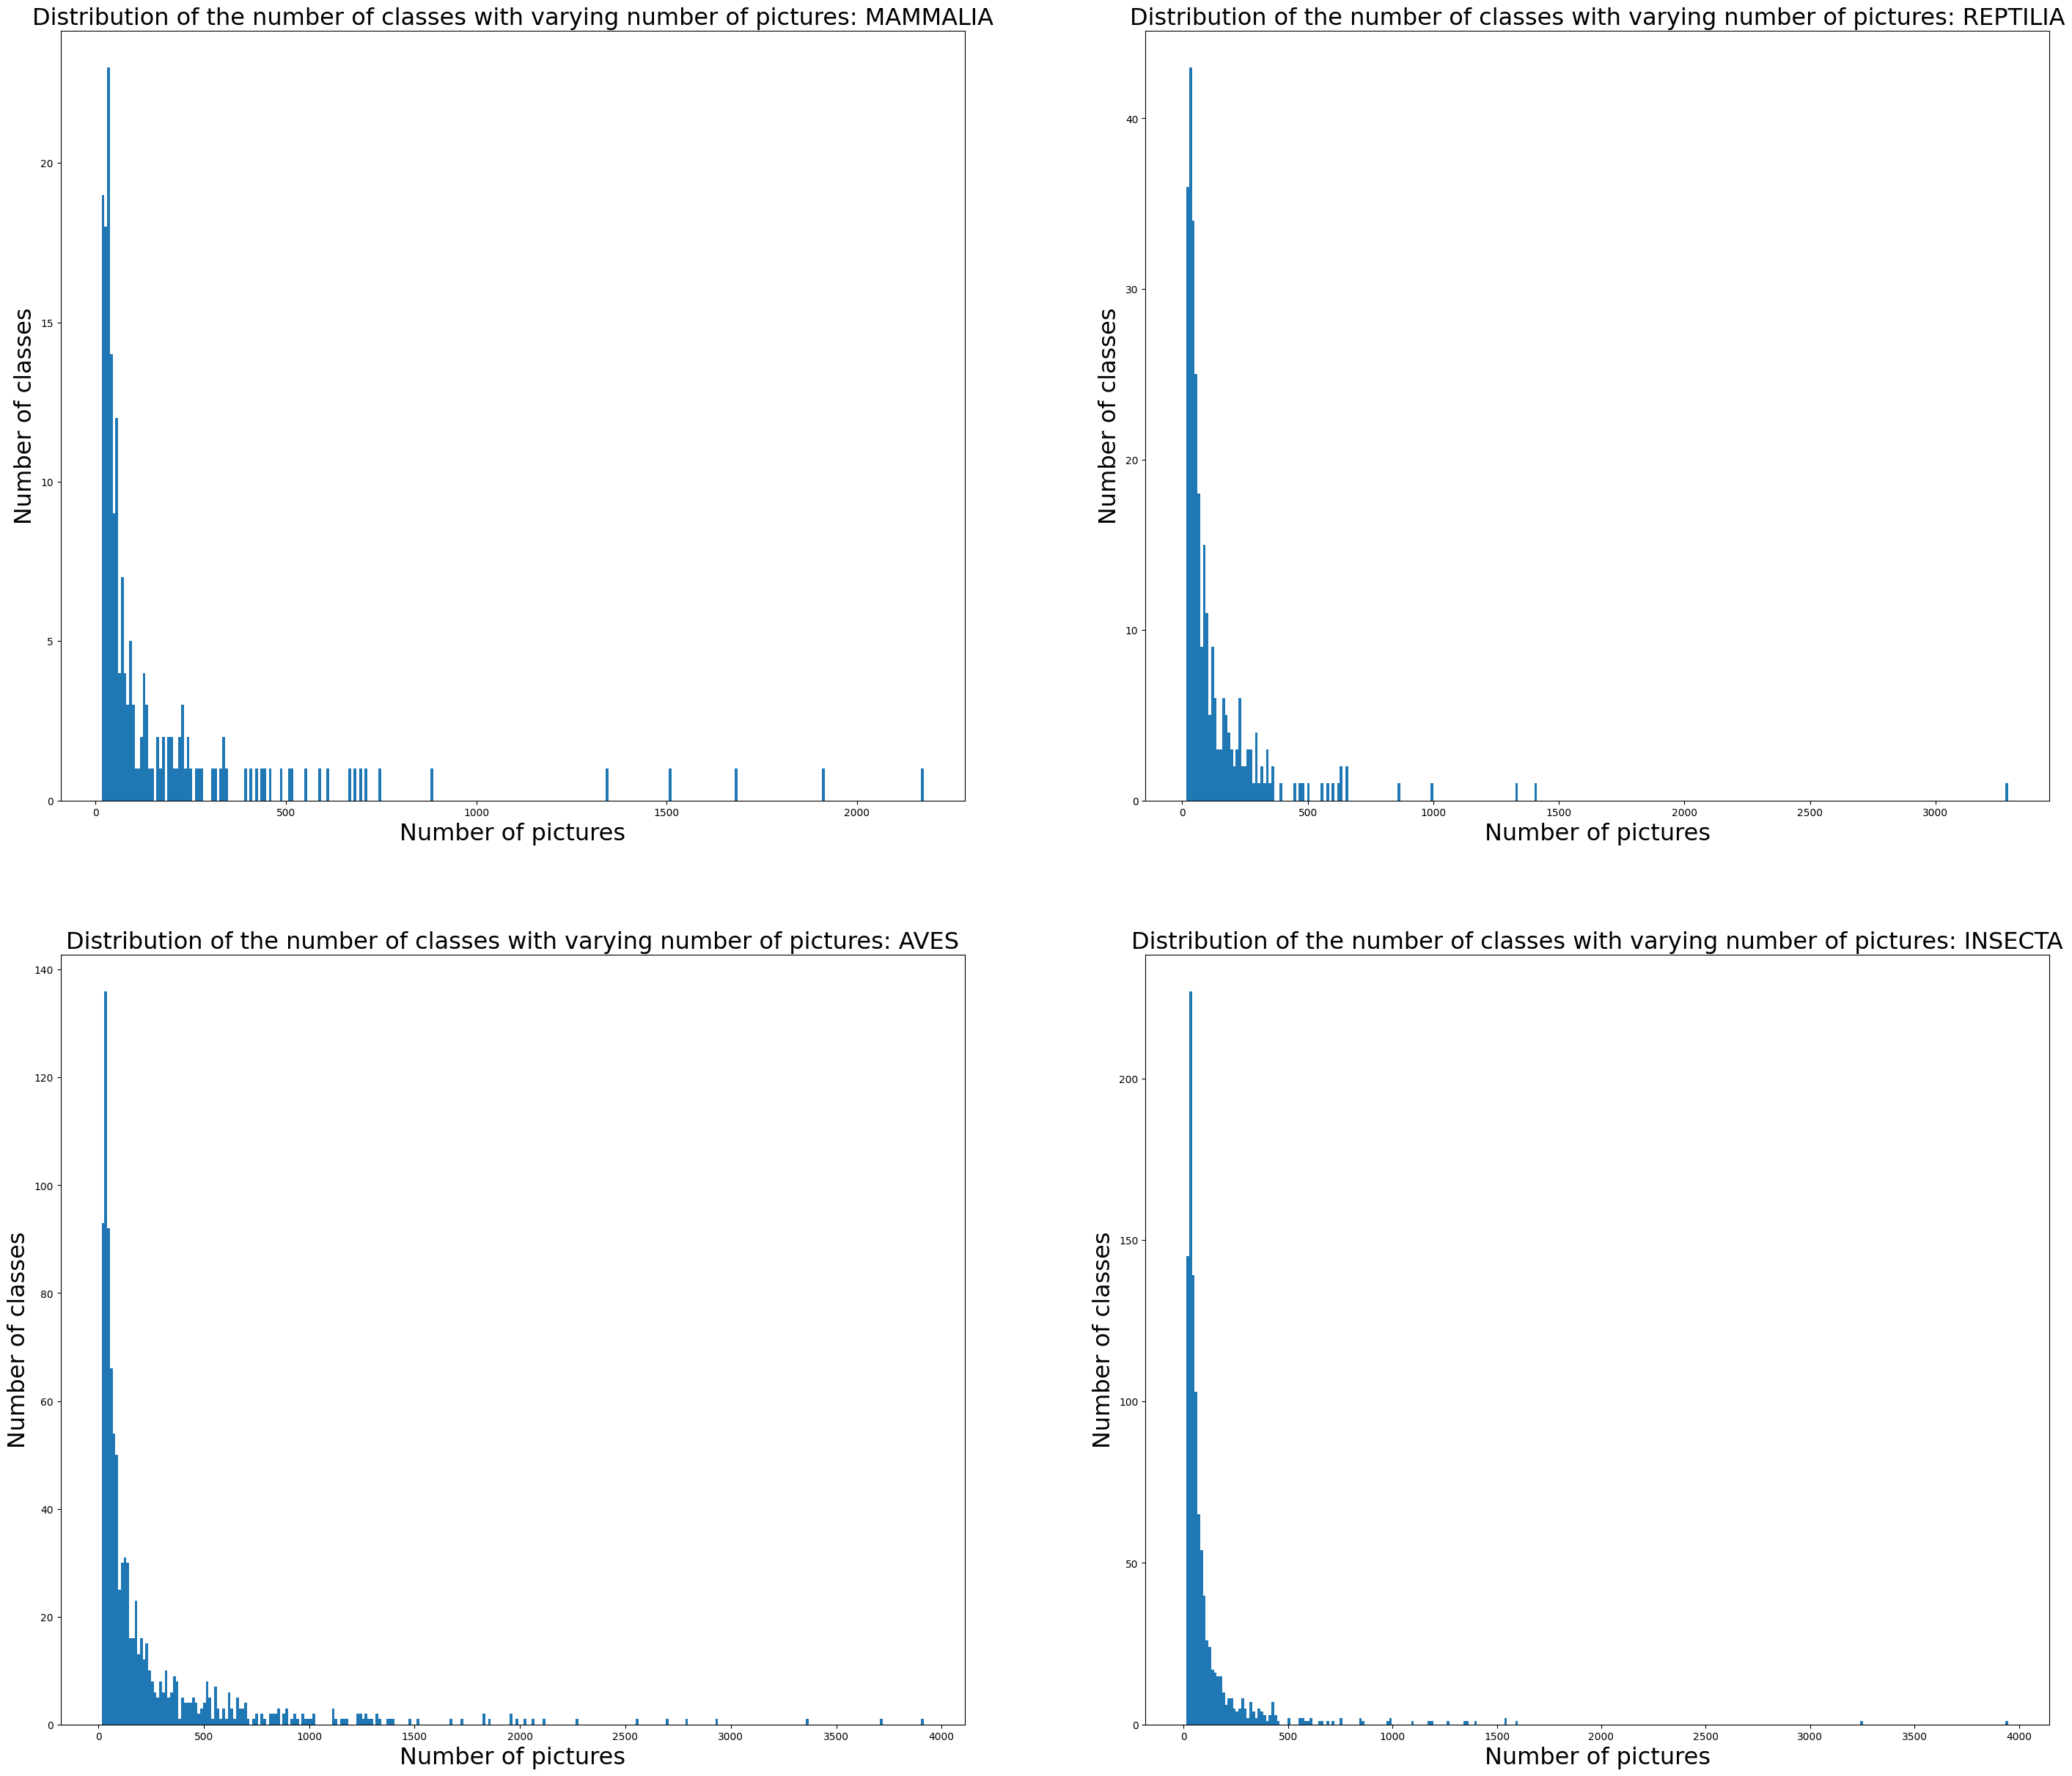

In [3]:
#Visualising the distribution classes with varying number of pictures
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (35,30))
ax = axes.ravel()

ax[0].hist(mammals_dist.values(), bins = 300)
#ax[0].set_xticks(np.arange(0, 4000, 200))
#ax[0].set_yticks(np.arange(0, 50, 5))
ax[0].set_title('Distribution of the number of classes with varying number of pictures: MAMMALIA', fontsize = 23)
ax[0].set_xlabel('Number of pictures', fontsize = 23)
ax[0].set_ylabel('Number of classes', fontsize = 23)

ax[1].hist(reptiles_dist.values(), bins = 300)
#ax[1].set_xticks(np.arange(0, 4000, 200))
#ax[1].set_yticks(np.arange(0, 50, 5))
ax[1].set_title('Distribution of the number of classes with varying number of pictures: REPTILIA', fontsize = 23)
ax[1].set_xlabel('Number of pictures', fontsize = 23)
ax[1].set_ylabel('Number of classes', fontsize = 23)

ax[2].hist(birds_dist.values(), bins = 300)
#ax[2].set_xticks(np.arange(0, 4000, 200))
#ax[2].set_yticks(np.arange(0, 50, 5))
ax[2].set_title('Distribution of the number of classes with varying number of pictures: AVES', fontsize = 23)
ax[2].set_xlabel('Number of pictures', fontsize = 23)
ax[2].set_ylabel('Number of classes', fontsize = 23)

ax[3].hist(insects_dist.values(), bins = 300)
#ax[3].set_xticks(np.arange(0, 4000, 200))
#ax[3].set_yticks(np.arange(0, 50, 5))
ax[3].set_title('Distribution of the number of classes with varying number of pictures: INSECTA', fontsize = 23)
ax[3].set_xlabel('Number of pictures', fontsize = 23)
ax[3].set_ylabel('Number of classes', fontsize = 23)
plt.show()

To begin our analysis we wanted to understand not only how many classes we had but also how they were distributed in terms of support and if there were any salient imbalances. From the plots above it indeed becomes evident that great imbalances in teh support that each class has are present. Indeed, the is a consistent amount of classes mostly encompassing the lower quartile of the distribution that have a support of less than 200 pictures. We deemed that removing pictures from these classes would not only allow us to retain a sufficient amount of data to train our model, but would also allow us to avoid having classes that would not have enough observations for the model to learn to classify. The latter would have just introduced noise in the model. We thus proceeded to remove these classes and continue our exploration on the remaining ones selected, namely 55 classes with 25150 pictures remaining.

## Exploratory Analysis: Part 1 Classes distribution and support

In [2]:
#Reading each species name and the amount of pictures for it
species_dist = defaultdict(int)

for i in os.listdir('Animals'):
    if i != '.DS_Store':
        species_dist[i]= len(os.listdir('Animals/'+i))

In [3]:
print(f'Number of distinct classes: {len(species_dist.keys())}')

Number of distinct classes: 12


In [5]:
import matplotlib.patches as mpatches
families = {'Sciurus carolinensis':'Mammal', 'Trachemys scripta elegans':'Reptile', 'Junonia coenia': 'Insect', 'Pandion haliaetus':'Bird', 'Pachydiplax longipennis':'Insect', 'Anolis carolinensis':'Reptile', 'Chelydra serpentina':'Reptile', 'Spinus tristis':'Bird', 'Procyon lotor':'Mammal', 'Harmonia axyridis':'Insect', 'Picoides pubescens':'Bird', 'Canis latrans':'Mammal'}
colors = {'Sciurus carolinensis':'y', 'Trachemys scripta elegans':'purple', 'Junonia coenia': 'brown', 'Pandion haliaetus':'orange', 'Pachydiplax longipennis':'brown', 'Anolis carolinensis':'purple', 'Chelydra serpentina':'purple', 'Spinus tristis':'orange', 'Procyon lotor':'y', 'Harmonia axyridis':'brown', 'Picoides pubescens':'orange', 'Canis latrans':'y'}
mammal_patch = mpatches.Patch(color='y', label='Mammal')
reptile_patch = mpatches.Patch(color='purple', label='Reptile')
insect_patch = mpatches.Patch(color='brown', label='Insect')
bird_patch = mpatches.Patch(color='orange', label='Bird')
handles = [mammal_patch, reptile_patch, insect_patch, bird_patch]

In [15]:
spec_df = pd.DataFrame({'species':species_dist.keys(), 'values':species_dist.values()})
spec_df['family'] = [families[i] for i in spec_df['species']]
spec_df['color'] = [colors[i] for i in spec_df['species']]
spec_df = spec_df.sort_values('color')
spec_df

,species,values,family,color
2,Junonia coenia,1546,Insect,brown
4,Pachydiplax longipennis,1596,Insect,brown
9,Harmonia axyridis,1355,Insect,brown
3,Pandion haliaetus,1825,Bird,orange
7,Spinus tristis,1332,Bird,orange
10,Picoides pubescens,1520,Bird,orange
1,Trachemys scripta elegans,1411,Reptile,purple
5,Anolis carolinensis,1330,Reptile,purple
6,Chelydra serpentina,995,Reptile,purple
0,Sciurus carolinensis,1681,Mammal,y


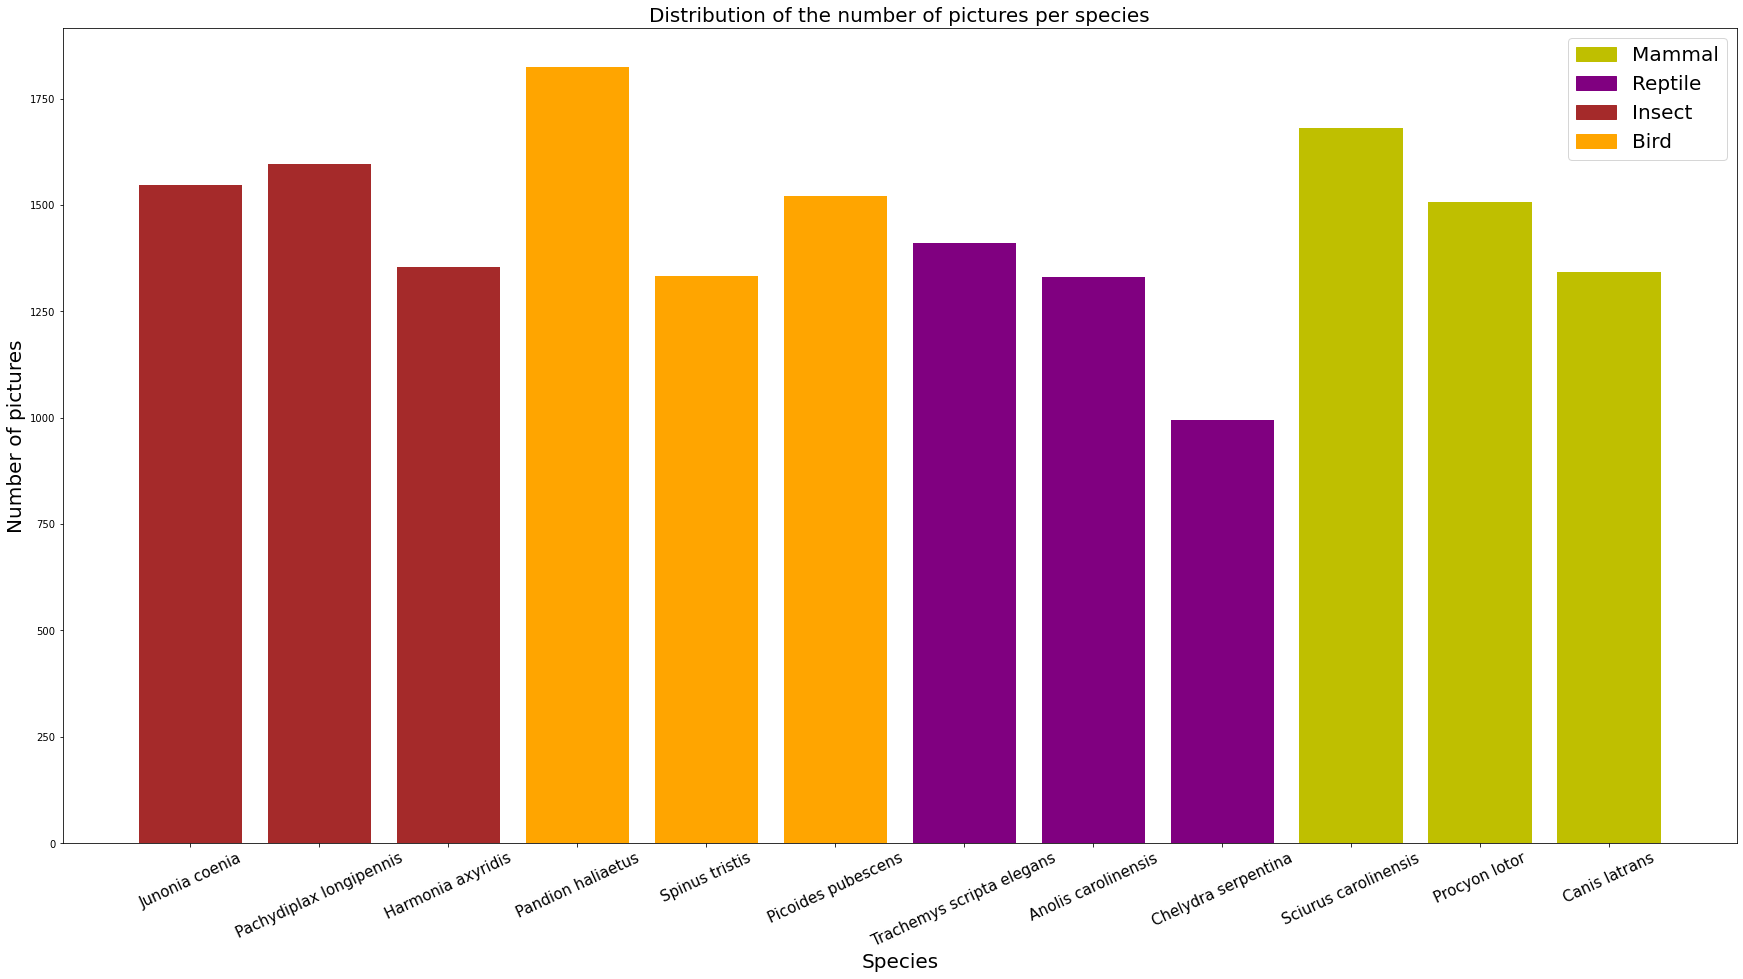

In [19]:
#Visualising the distribution classes with varying number of pictures
plt.figure(figsize = (30,15))
plt.bar(spec_df['species'], spec_df['values'], color = spec_df['color'] )
plt.title('Distribution of the number of pictures per species', fontsize = 20)
plt.xlabel('Species', fontsize = 20)
plt.ylabel('Number of pictures', fontsize = 20)
plt.tick_params(axis='x', labelsize=15, rotation = 25)
plt.legend(handles = handles, fontsize = 20)
plt.show()

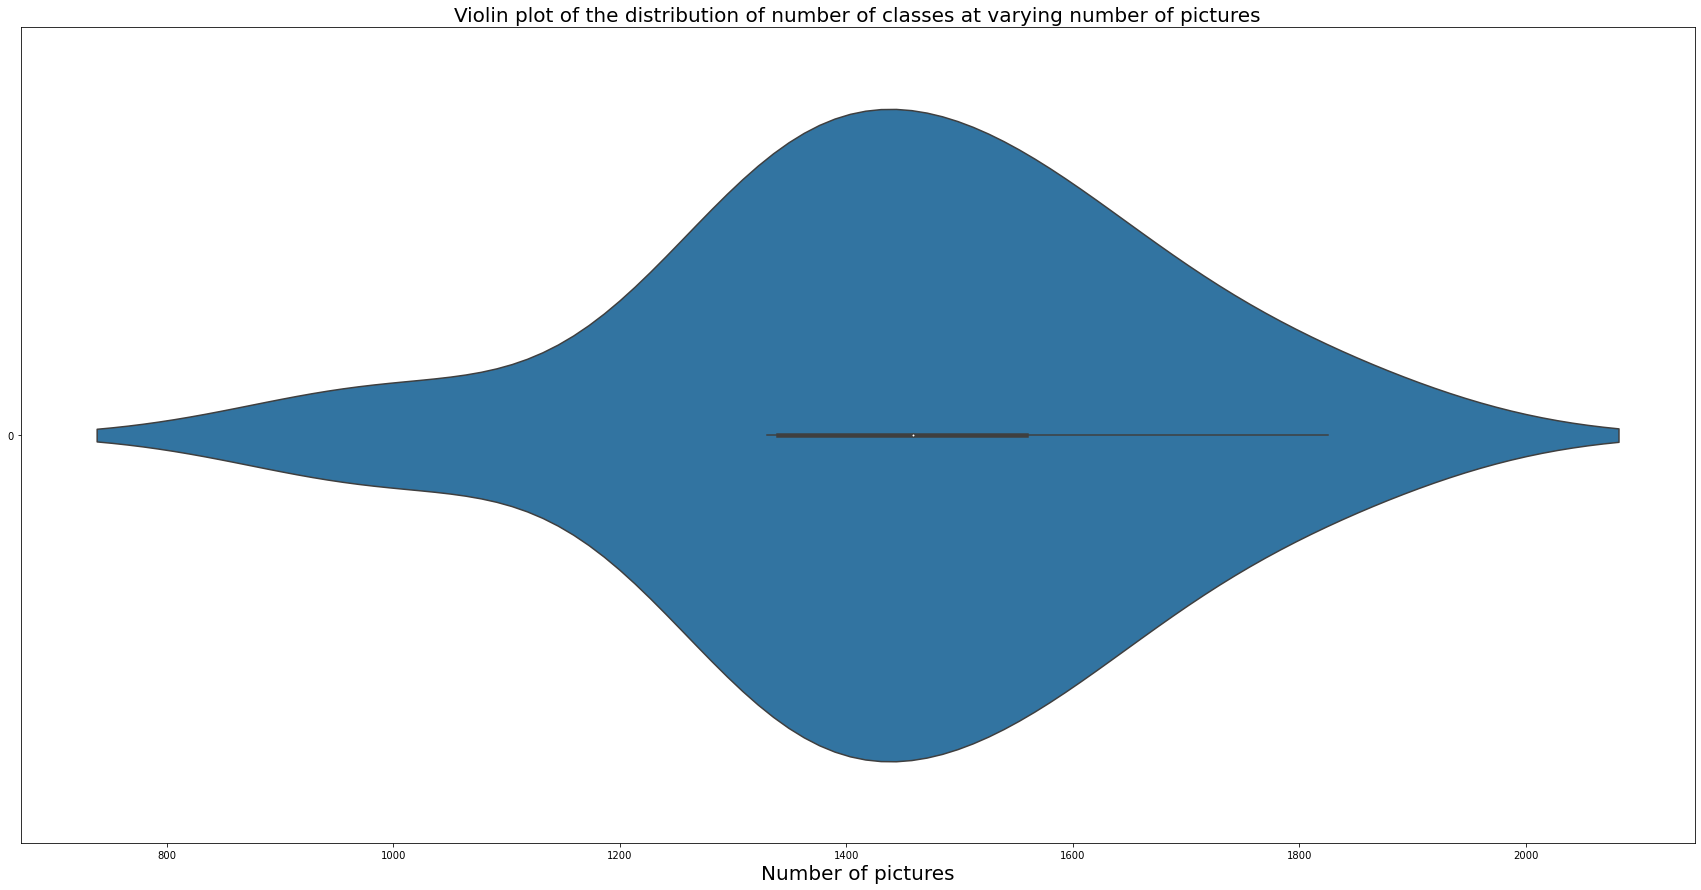

In [13]:
#Visualising a violin plot for both the distribution density and the boxplot
plt.figure(figsize = (30,15))
sb.violinplot([i for i in species_dist.values()], orient = 'h')
plt.title('Violin plot of the distribution of number of classes at varying number of pictures', fontsize = 20)
plt.xlabel('Number of pictures', fontsize = 20)
plt.show()

In [14]:
#Saving as a df to manipulate better
species_clean = pd.DataFrame({'Class_name':species_dist.keys(), 'N_pictures':species_dist.values()})
species_clean.shape

(12, 2)

Upon plotting the distribution of the selected pictures we can see that it is pretty balanced. We will be working only with this one from now on.

## Exploratory analysis: Part 2 Understanding the classes

Having explored the classes distrubution and their support our next step was to understand the content of each class and how that mapped in to our picture space. We begin by simply printing an example of each class to understand the type of animals that are present. Our analysis the divides in to two further sub-parts.

1. 'Physical' attributes and similarity of pictures: with this we mean the how are pictures distributed/similar in terms of functional attributes like height, width...

2. 'Conceptual' attributes and similarity of pictures: How are pictures distributed/similar in terms of what they represent at a conceptual level, so the meaning of their content/ the animal they have in the picture.

In [39]:
#Selecting the first picture from each of the remaining classes
sample_pics = []
for i in species_clean['Class_name']:
    pic = os.listdir('Animals/'+i)[7]
    sample_pics.append('Animals/'+i+'/'+pic)

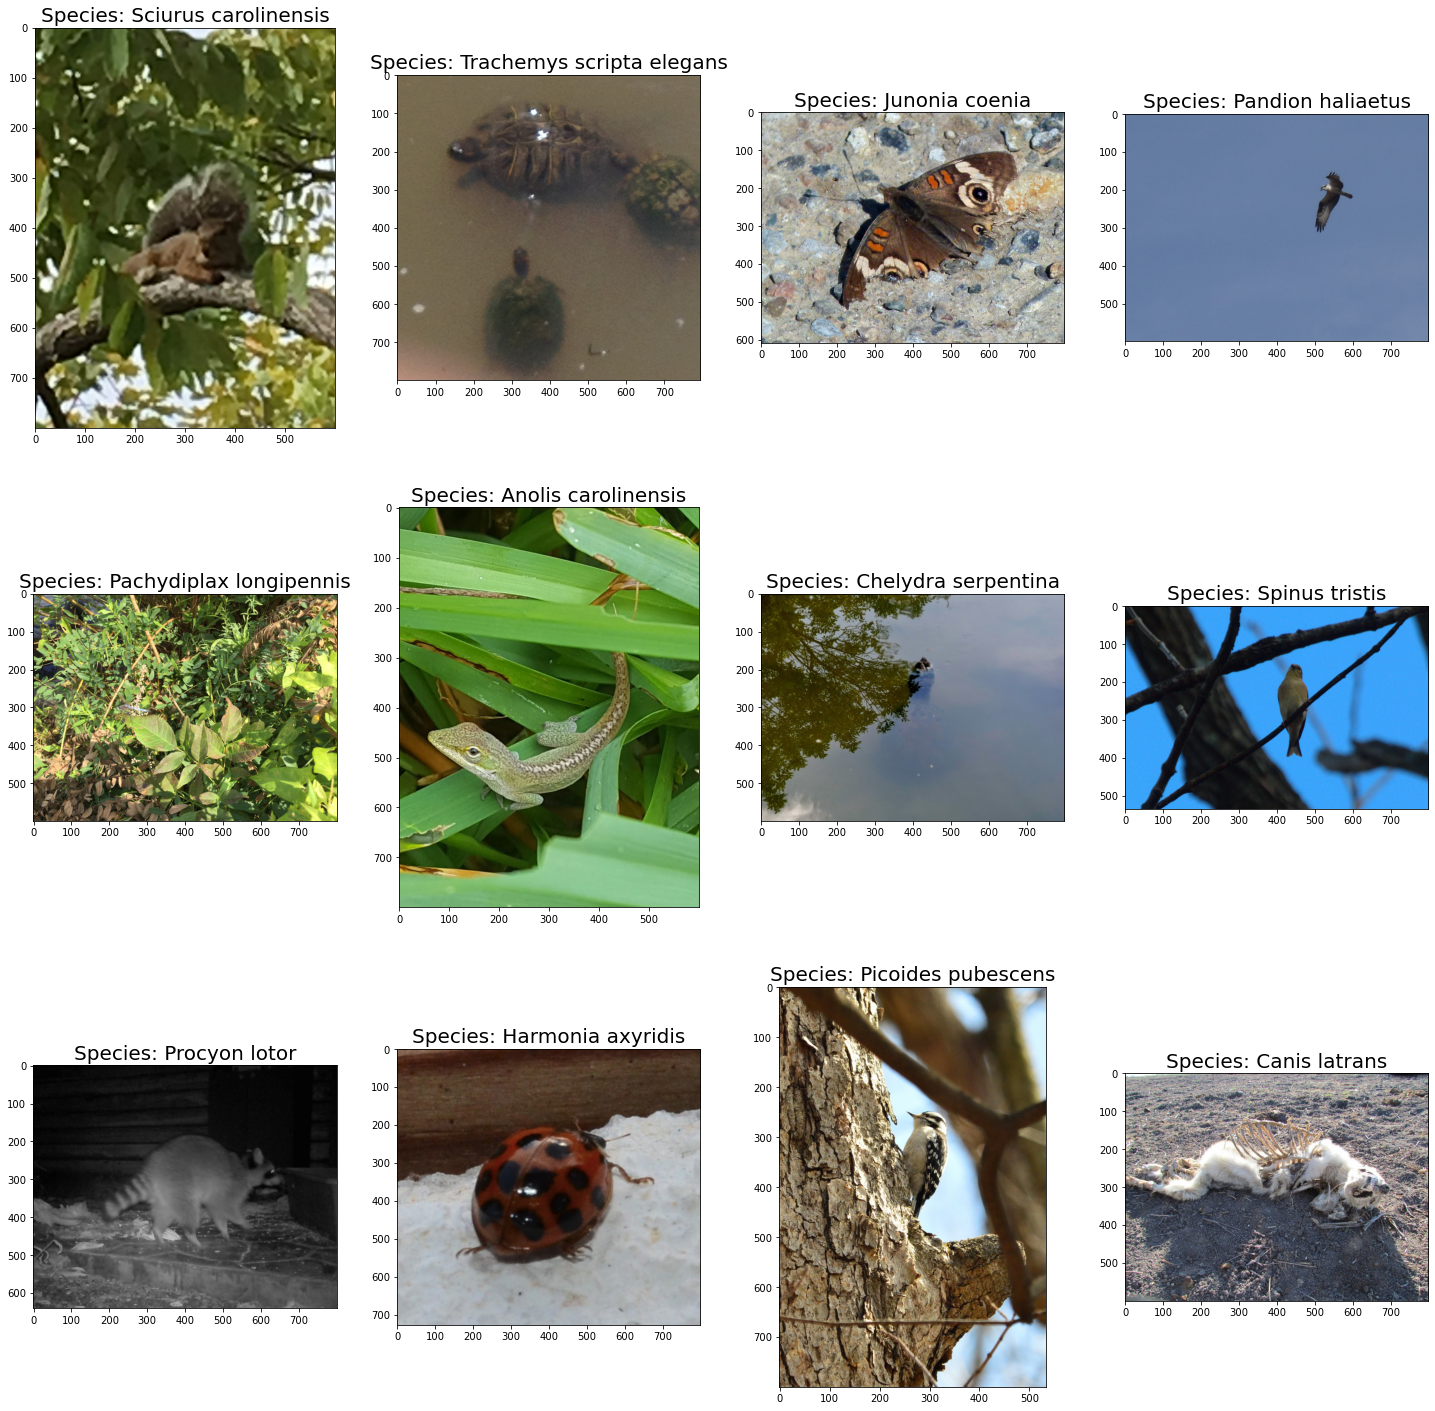

In [40]:
#Plotting one example from each remaining class
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(25,25))
axs=axs.ravel()
for ax, pic in zip(axs, sample_pics):
    img = mpimg.imread(pic)
    ax.imshow(img)
    ax.set_title('Species: ' + pic.split('/')[1], fontsize = 20)
plt.show()

### 2.1: 'Physical' attrubutes and similarity of pictures

In [41]:
label_mapper = dict()
pictures = dict()
for id, dir in enumerate(os.listdir('Animals')):
    if dir != '.DS_Store':
        label_mapper[id] = dir
        for img in os.listdir('Animals/'+ dir):
            if img != '.DS_Store':
                pictures['Animals/'+ dir+'/'+os.path.relpath(img)] = dir

In [42]:
#Extracting means of colors of every picture
red_m = defaultdict(list)
red_sd = defaultdict(list)
green_m = defaultdict(list)
green_sd = defaultdict(list)
blue_m = defaultdict(list)
blue_sd = defaultdict(list)
avg_m = defaultdict(list)
avg_sd = defaultdict(list)
height = []
width = []
aspect_ratio =[]
empty = 0

for i in tqdm(list(pictures.keys())):
    try:
        pic = mpimg.imread(i)
        red_m[pictures[i]].append(np.mean(pic[:,:,0]))
        red_sd[pictures[i]].append(np.std(pic[:,:,0]))
        green_m[pictures[i]].append(np.mean(pic[:,:,1]))
        green_sd[pictures[i]].append(np.std(pic[:,:,1]))
        blue_m[pictures[i]].append(np.mean(pic[:,:,2]))
        blue_sd[pictures[i]].append(np.std(pic[:,:,2]))
        avg_m[pictures[i]].append(np.mean(pic))
        avg_sd[pictures[i]].append(np.std(pic))
        height.append(pic.shape[0])
        width.append(pic.shape[1])
        aspect_ratio.append(pic.shape[1]/pic.shape[0])
    except:
        empty+=1

100%|██████████| 17439/17439 [07:02<00:00, 41.30it/s]


In [43]:
#Extracting means of means
mm_r = defaultdict(int)
sdm_r = defaultdict(list)
mm_g = defaultdict(int)
sdm_g = defaultdict(list)
mm_b = defaultdict(int)
sdm_b = defaultdict(list)
mm_av = defaultdict(int)
sdm_av = defaultdict(list)

for i in red_m.keys():
    mm_r[i]=np.mean(red_m[i])
    sdm_r[i] = np.std(red_m[i])
    mm_g[i]=np.mean(green_m[i])
    sdm_g[i] = np.std(green_m[i])
    mm_b[i]=np.mean(blue_m[i])
    sdm_b[i] = np.std(blue_m[i])
    mm_av[i]=np.mean(avg_m[i])
    sdm_av[i] = np.std(avg_m[i])

In [44]:
# Generating patches fro subsequent plot
import matplotlib.patches as mpatches
families = {'Sciurus carolinensis':'Mammal', 'Trachemys scripta elegans':'Reptile', 'Junonia coenia': 'Insect', 'Pandion haliaetus':'Bird', 'Pachydiplax longipennis':'Insect', 'Anolis carolinensis':'Reptile', 'Chelydra serpentina':'Reptile', 'Spinus tristis':'Bird', 'Procyon lotor':'Mammal', 'Harmonia axyridis':'Insect', 'Picoides pubescens':'Bird', 'Canis latrans':'Mammal'}
colors = {'Sciurus carolinensis':'y', 'Trachemys scripta elegans':'purple', 'Junonia coenia': 'brown', 'Pandion haliaetus':'orange', 'Pachydiplax longipennis':'brown', 'Anolis carolinensis':'purple', 'Chelydra serpentina':'purple', 'Spinus tristis':'orange', 'Procyon lotor':'y', 'Harmonia axyridis':'brown', 'Picoides pubescens':'orange', 'Canis latrans':'y'}
mammal_patch = mpatches.Patch(color='y', label='Mammal')
reptile_patch = mpatches.Patch(color='purple', label='Reptile')
insect_patch = mpatches.Patch(color='brown', label='Insect')
bird_patch = mpatches.Patch(color='orange', label='Bird')
handles = [mammal_patch, reptile_patch, insect_patch, bird_patch]

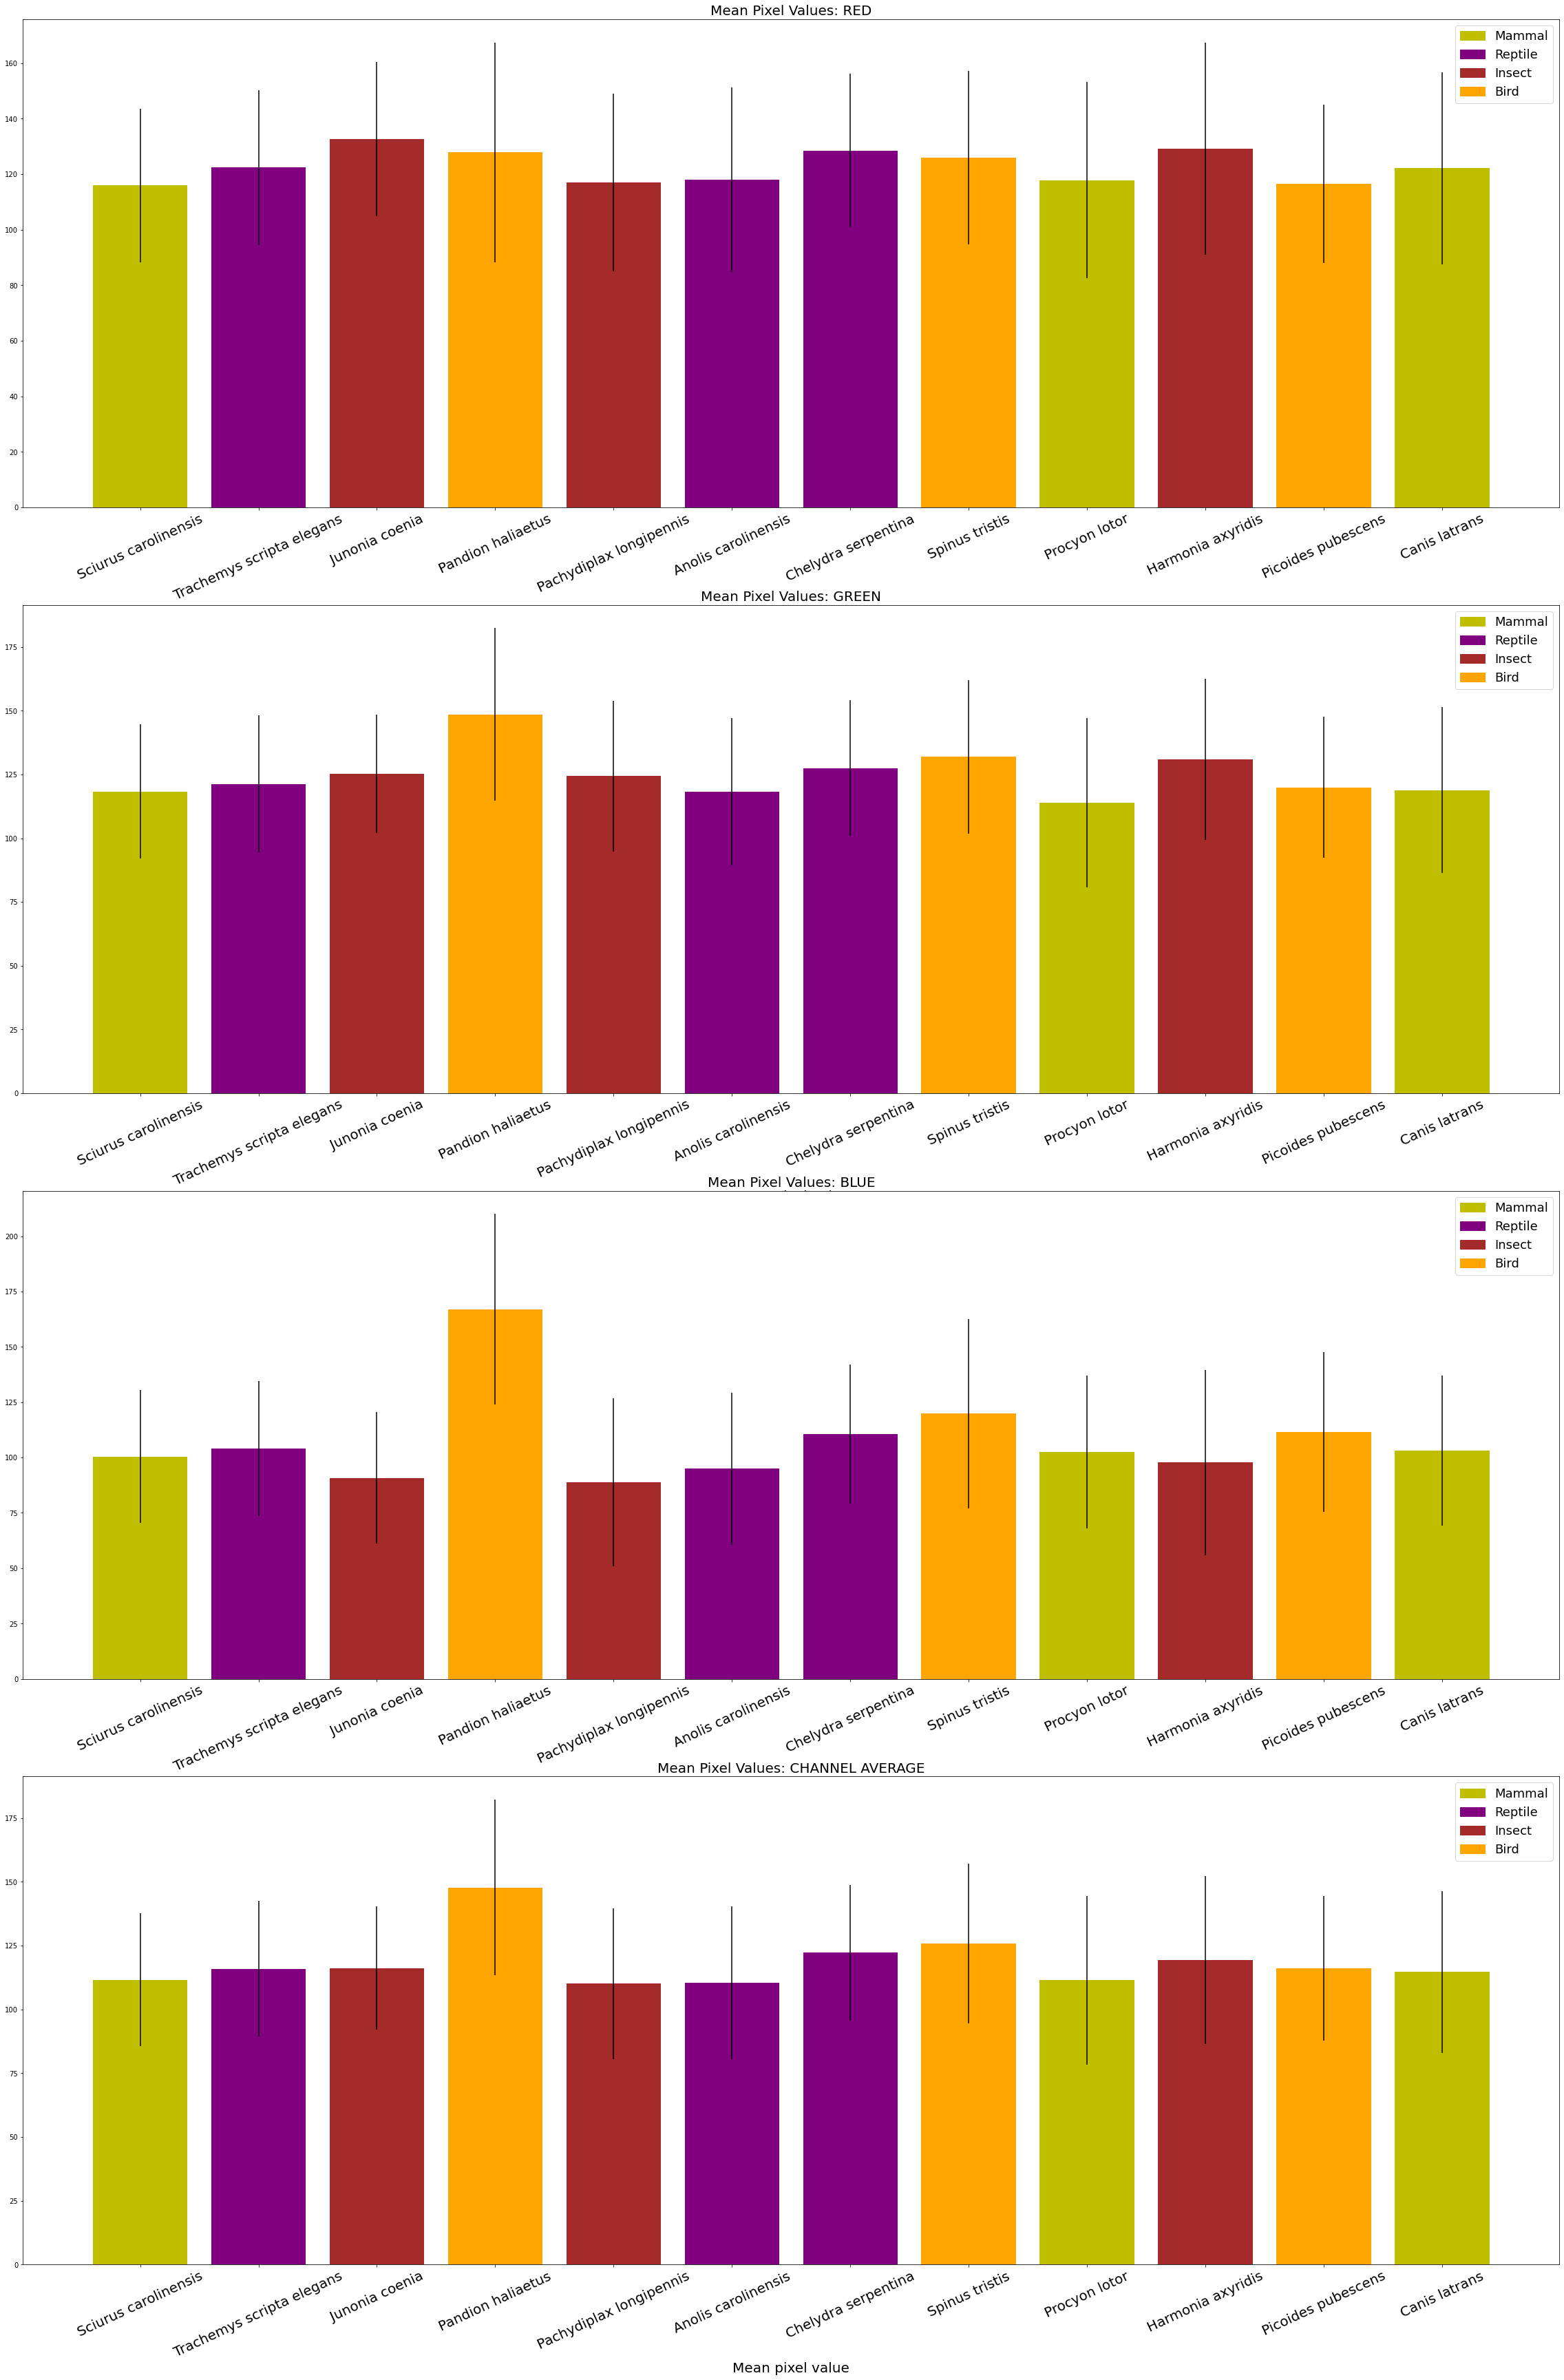

In [54]:
#Plotting means for each channel and species
fig, axs = plt.subplots(nrows = 4, figsize = (40,60))
axs = axs.ravel()
axs[0].bar(mm_r.keys(), mm_r.values(), yerr = sdm_r.values(), color = colors.values())
axs[0].legend(handles = handles, fontsize = 18)
axs[0].set_title('Mean Pixel Values: RED', fontsize = 20)
axs[0].set_xlabel('Mean pixel value',fontsize = 20)
axs[0].tick_params(axis='x', labelsize=20, rotation  = 25)

axs[1].bar(mm_g.keys(), mm_g.values(), yerr = sdm_g.values(), color = colors.values())
axs[1].legend(handles = handles, fontsize = 18)
axs[1].set_title('Mean Pixel Values: GREEN', fontsize = 20)
axs[1].set_xlabel('Mean pixel value', fontsize = 20)
axs[1].tick_params(axis='x', labelsize=20, rotation =25 )


axs[2].bar(mm_b.keys(), mm_b.values(), yerr = sdm_b.values(), color = colors.values())
axs[2].legend(handles = handles, fontsize = 18)
axs[2].set_title('Mean Pixel Values: BLUE', fontsize = 20)
axs[2].set_xlabel('Mean pixel value', fontsize = 20)
axs[2].tick_params(axis='x', labelsize=20, rotation = 25)

axs[3].bar(mm_av.keys(), mm_av.values(), yerr = sdm_av.values(), color = colors.values())
axs[3].legend(handles = handles, fontsize = 18)
axs[3].set_title('Mean Pixel Values: CHANNEL AVERAGE', fontsize = 20)
axs[3].set_xlabel('Mean pixel value', fontsize = 20)
axs[3].tick_params(axis='x', labelsize=20, rotation = 25)

plt.show()

From the above plots we can see there are no major differences overall in the mean color values of each species across each color channel. Indeed it only seems that  a particular bird species might have slightly higher blue colors, but this is understandable consoidering that many pictures could have been taken while the bird was in flight on teh backdrop of a blue sky.

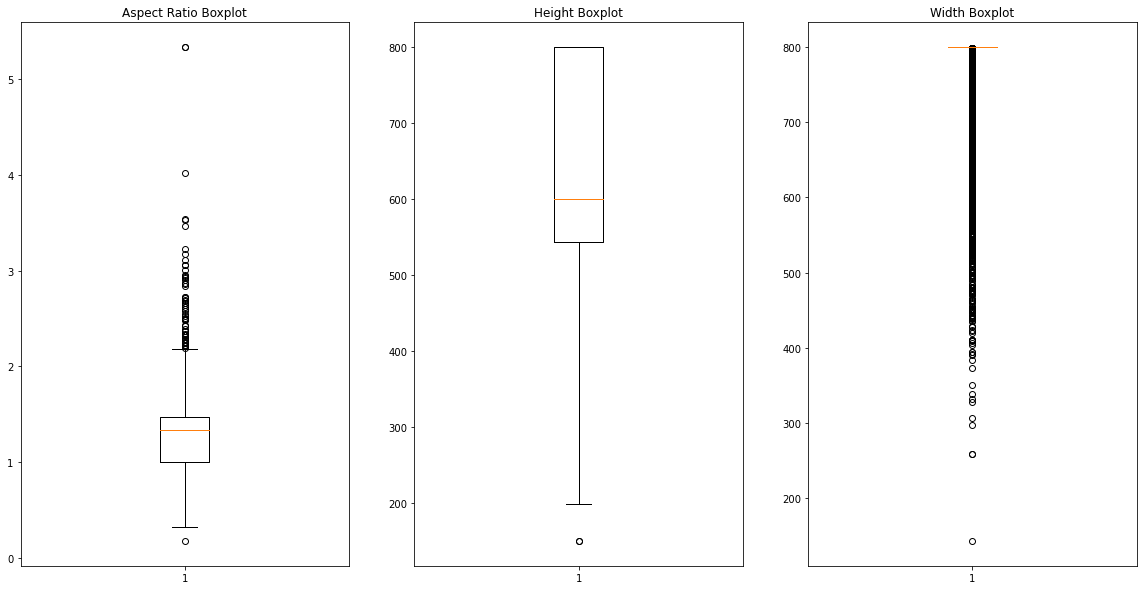

In [46]:
fig, axes = plt.subplots(nrows = 1, ncols =3, figsize = (20,10))
axes = axes.ravel()
axes[0].boxplot(aspect_ratio)
axes[1].boxplot(height)
axes[2].boxplot(width)
axes[0].set_title('Aspect Ratio Boxplot')
axes[1].set_title('Height Boxplot')
axes[2].set_title('Width Boxplot')
plt.show()

Indeed from these graphs we cann see that there is an overall pretty high spread in the values of the height and width of the pictures. Overall there are many data points that diverge from the maximum size of 800x800 pixels, thus suggestinng that both due to this spread, and for computational resons it might be better to find a different size to rehsape the pictures by.

#### Saving paths of selected pictures
In order to facilitate our experiments with Neural Networks later in our work we run the below defined function to save all the lables and paths of the selected pictures in a csv file.

In [47]:
labels = []
paths = []
for i in os.listdir('Animals'):
    if i!= '.DS_Store':
        new_path='Animals'+'/'+i
        paths+=[new_path+'/'+k for k in os.listdir(new_path)]
        labels+=[i for _ in range(len(os.listdir(new_path)))]
        print('Num photos', i ,':', len(os.listdir(new_path)))
print('\nTotal Photos:', len(paths), '----','Number of labels:', len(set(labels)))
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
labels = le.fit_transform(labels)
paths_df = pd.DataFrame([paths, labels]).T.rename({0:'path', 1:'label'}, axis=1)
paths_df['label']=paths_df['label'].astype('str')
paths_df.to_csv('12paths_df.csv', index = False)

Num photos Sciurus carolinensis : 1681
Num photos Trachemys scripta elegans : 1411
Num photos Junonia coenia : 1546
Num photos Pandion haliaetus : 1825
Num photos Pachydiplax longipennis : 1596
Num photos Anolis carolinensis : 1330
Num photos Chelydra serpentina : 995
Num photos Spinus tristis : 1332
Num photos Procyon lotor : 1506
Num photos Harmonia axyridis : 1355
Num photos Picoides pubescens : 1520
Num photos Canis latrans : 1342

Total Photos: 17439 ---- Number of labels: 12


### 2.2 'Conceptual' attributes and similarity of pictures

As part of our exploratory analysis we decided to use transfer learning and extract feature vectores of our dataset so as to better understand if there were any innate groups or cluster that would potentially form across different species. This is going to be important to understand how our dataset is formed als in temrs of the context that the different species are in. We hipothesise it could help us identify and validate existing segmentations that will also hopefully help our model to distinguish species by context later in our experiments. In order to have more interpretable pictures in thsi visualisation (since plotting 25000+ points would make it hard and not visually pleasing to see potential clusters) we are selecting a random sample from each species using the function defined below.

#### Loading the model to extract the features and sampling the data
This subsection loads the ResNet model and prepares data to be passed for clustering purposes.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Model

base_model = ResNet50(weights='imagenet')  # Read the ImageNet pre-trained ResNet50 model
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)  # We use the output from avg_pool

def extract_feature(model, img):
    # This function takes a RGB image, then return a feature vector.
    x = np.array(tf.image.resize(img, (224, 224))) 
    x = np.float32(x)  # Convert from uint8 to float32
    x = np.expand_dims(x, axis=0)  
    x = preprocess_input(x)  # Subtract the average value of ImagNet for adequating your image to the format the model requires
    feature = model.predict(x, verbose = 0)[0]  # Extract a feature
    feature /= np.linalg.norm(feature)  # Normalize the feature.
    return feature

102967424/102967424 [==============================] - 5s 0us/step


In [4]:
train_val = pd.read_csv('/content/drive/MyDrive/train_val_data_2.csv')
for i in range(len(train_val['path'])):
    train_val.loc[i, 'path'] = '/content/drive/MyDrive/' + train_val.loc[i, 'path']
train_val.head()

,path,label
0,/content/drive/MyDrive/Animals/Junonia coenia/...,4
1,/content/drive/MyDrive/Animals/Pachydiplax lon...,5
2,/content/drive/MyDrive/Animals/Sciurus carolin...,9
3,/content/drive/MyDrive/Animals/Pandion haliaet...,6
4,/content/drive/MyDrive/Animals/Sciurus carolin...,9


In [5]:
def path_sampler(df,label_column, column_to_sample, n_per_group = 2, replace = False, seed = 8):
    '''This functon allows to select a subset of the data by saving paths to each observation
    Input: df with all the paths, 
    name of column with lables, 
    name of column with paths, 
    desired observation numbers per group
    
    Returns: df with selected subsample'''
    
    np.random.seed(seed)
    p_samp = []
    lab_samp = []
    for i in set(df[label_column]):
        selected = np.array(df[df[label_column]==i][column_to_sample])
        sample = np.random.choice(selected, size = n_per_group, replace = replace)
        p_samp+=list(sample)
        lab_samp += [i]*n_per_group
    return pd.DataFrame({column_to_sample:p_samp, label_column:lab_samp})

In [6]:
#runing path sampler to select 100 images per class 
#(=1200 pictures that should be enough to see emergence of clusters)

for_clustering = path_sampler(train_val, 'label', 'path', n_per_group = 100)

#Reading selected paths as arrays for clustering
arrays_clust = [np.array(PIL.Image.open(i)) for i in tqdm(list(for_clustering['path']))]

100%|██████████| 1200/1200 [18:15<00:00,  1.10it/s]


#### Extracting the features and running clustering
This section applies clustering to the samples of pictures selected from each specie.

In [7]:
#Extracting features from the model
from matplotlib.image import imread
np.random.seed(4)
features = []
labels = []
for i in tqdm(range(len(arrays_clust))):
    try:
        features.append(extract_feature(model, arrays_clust[i]))
        labels.append(for_clustering.loc[i, 'label'])

    except:
        PIL.Image.fromarray(arrays_clust[i])
features = np.array(features)

100%|██████████| 1200/1200 [01:18<00:00, 15.20it/s]


In [8]:
#Dimensionality reduction using tsne for visualization
from sklearn.manifold import TSNE
np.random.seed(4)

tsne = TSNE(n_components=2)
twod_tsne = tsne.fit_transform(features) 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


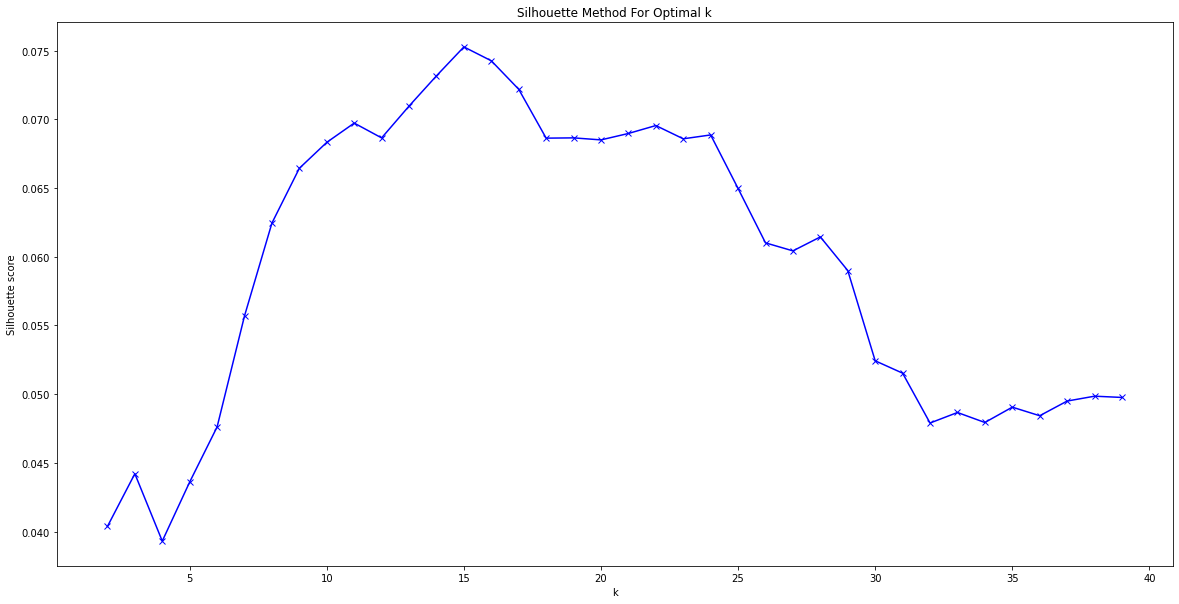

In [9]:
#Using silouhette score to find optimal cluster numbers
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering


silhouettes = []

K = range(2, 40)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(features)
    score = silhouette_score(features, agg_cluster_ids)
    silhouettes.append(score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [10]:
#Clustering with chosen number of clusters
from sklearn.cluster import KMeans
n_clusters = 12 
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)

In [11]:
#Plotting example images from each cluster
import warnings
warnings.filterwarnings("ignore")
for k in range(n_clusters):
    print("Cluster id: k={}".format(k))
    img_ids = [img_id for img_id, cluster_id in enumerate(kmeans.labels_) if cluster_id == k]

    cols = 10
    img_ids = img_ids[0:cols] if cols < len(img_ids) else img_ids # Let's see the top 10 results
    
    # Visualize images assigned to this cluster
    imgs = np.array(arrays_clust)[img_ids]
    plt.figure(figsize=(20, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

It is interesting to note that clusters almost uniquely identify a background/an animal.

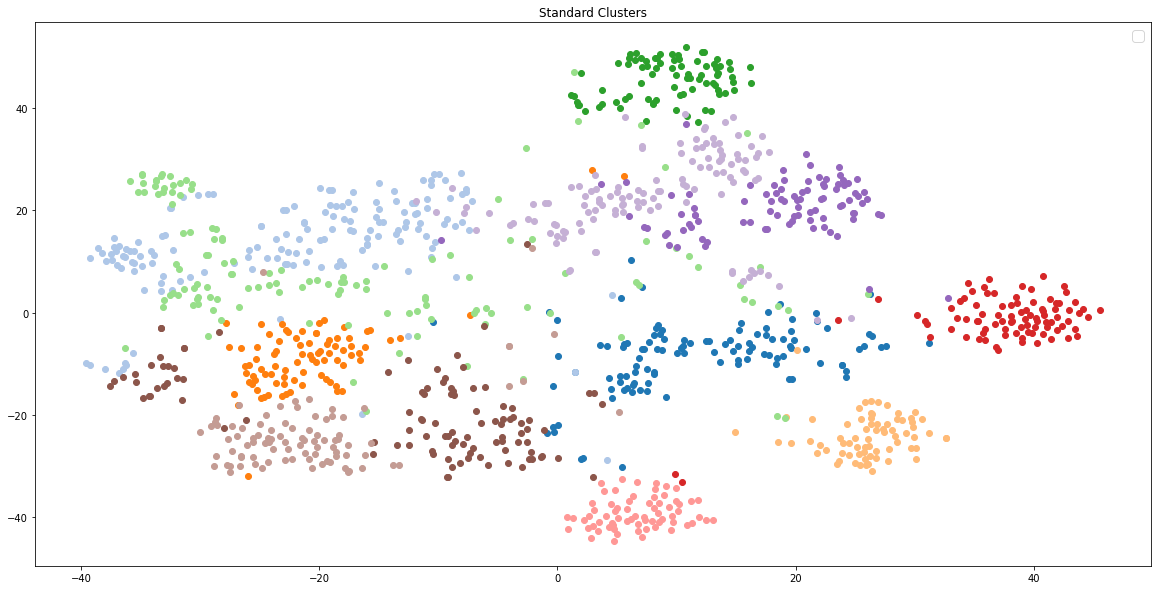

In [12]:
colors = plt.get_cmap("tab20")

plt.figure(figsize = (20,10))
plt.title('Standard Clusters')
for c in set(kmeans.labels_):
    indices = np.where(kmeans.labels_==c)
    plt.scatter(twod_tsne[indices,0], twod_tsne[indices, 1], color=colors(c))
plt.legend(fontsize = 15)
plt.show()

In [13]:
#Generating a dataframe with the label of each image and the cluster it belongs to 
preds = pd.DataFrame()
preds['clusters'] = kmeans.labels_
preds['label'] = labels
preds.head()

,clusters,label
0,0,0
1,0,0
2,5,0
3,0,0
4,0,0


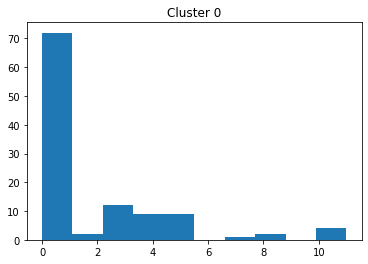

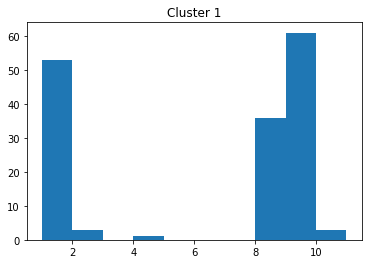

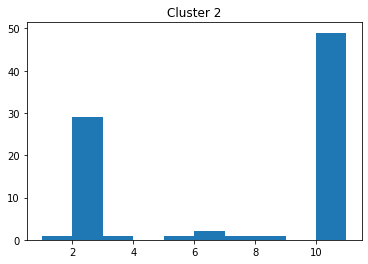

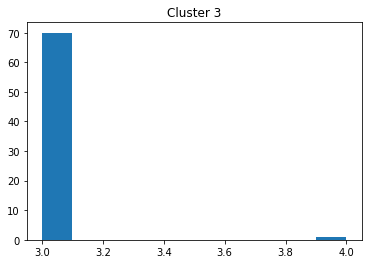

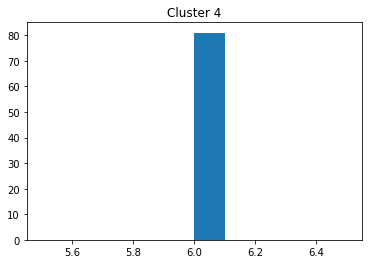

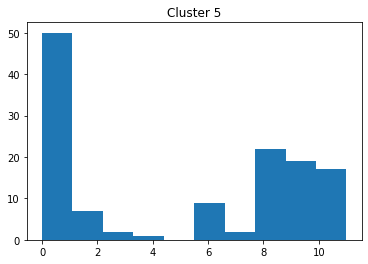

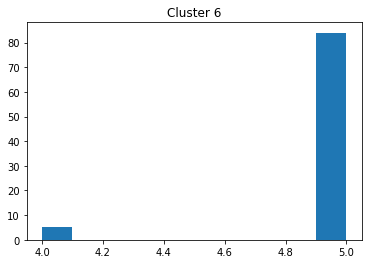

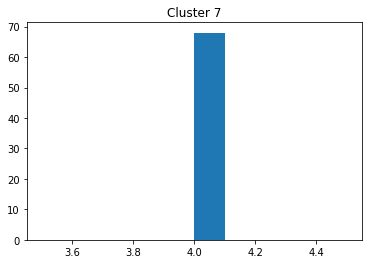

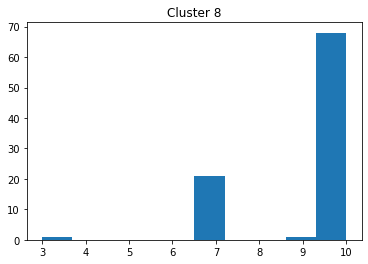

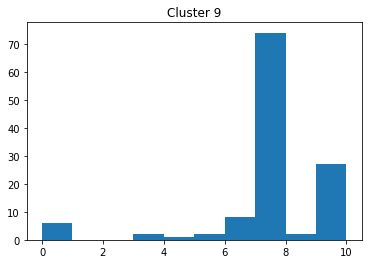

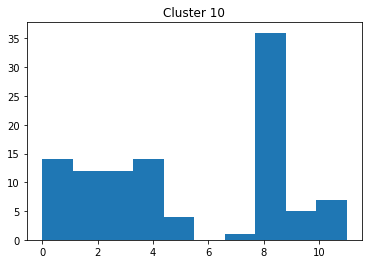

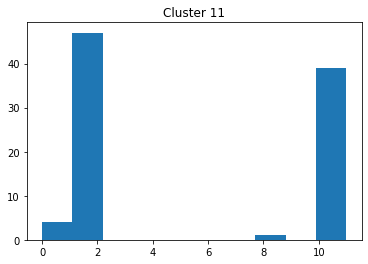

In [14]:
#Visualizing species distribution within each identified cluster
for clust in set(preds['clusters']):
  plt.hist(preds.loc[preds['clusters'] == clust, 'label'], density = False)
  plt.title(f'Cluster {clust}')
  plt.show()

In [ ]:
preds.to_csv('/content/drive/MyDrive/vgg_standard_predictions.csv')